In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

2024-06-02 10:26:07.082112: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 10:26:07.082186: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 10:26:07.082211: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-02 10:26:07.089850: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('dataset/windows/windowed_2.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810624 entries, 0 to 810623
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   time    810624 non-null  int64 
 1   A_F     810624 non-null  int64 
 2   A_V     810624 non-null  int64 
 3   A_L     810624 non-null  int64 
 4   L_F     810624 non-null  int64 
 5   L_V     810624 non-null  int64 
 6   L_L     810624 non-null  int64 
 7   T_F     810624 non-null  int64 
 8   T_V     810624 non-null  int64 
 9   T_L     810624 non-null  int64 
 10  Action  810624 non-null  int64 
 11  name    810624 non-null  object
dtypes: int64(11), object(1)
memory usage: 74.2+ MB


In [4]:
# 'name' 열에서 2, 3번째 숫자를 추출하여 새로운 열 'user_number' 생성
df['user_number'] = df['name'].str[1:3]

# 'user_number' 열을 int형으로 변환
df['user_number'] = df['user_number'].astype(int)

# 기존 'name' 열 삭제
df.drop(columns=['name'], inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810624 entries, 0 to 810623
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   time         810624 non-null  int64
 1   A_F          810624 non-null  int64
 2   A_V          810624 non-null  int64
 3   A_L          810624 non-null  int64
 4   L_F          810624 non-null  int64
 5   L_V          810624 non-null  int64
 6   L_L          810624 non-null  int64
 7   T_F          810624 non-null  int64
 8   T_V          810624 non-null  int64
 9   T_L          810624 non-null  int64
 10  Action       810624 non-null  int64
 11  user_number  810624 non-null  int64
dtypes: int64(12)
memory usage: 74.2 MB


In [6]:
df.shape

(810624, 12)

In [7]:
df['Action'].value_counts()

0    677184
1    103104
2     30336
Name: Action, dtype: int64

In [8]:
# status 열에서 값이 0인 행 제거
df = df[df['Action'] != 0]

# status 열에서 값이 1인 행을 0으로, 값이 2인 행을 1로 바꾸기
df['Action'] = df['Action'].replace({1: 0, 2: 1})

In [9]:
df['Action'].value_counts()

0    103104
1     30336
Name: Action, dtype: int64

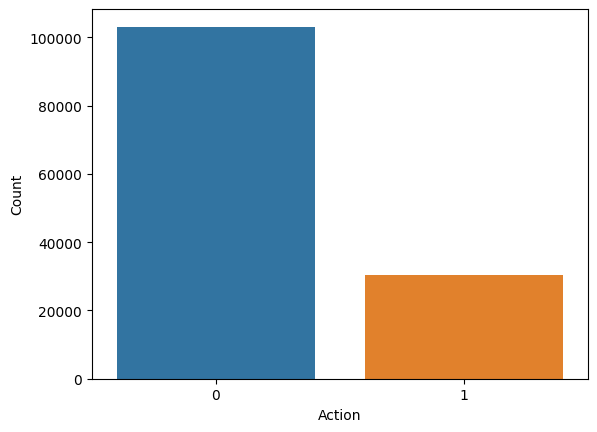

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and '0' is the column name
# Ensure the column is of categorical dtype
df['Action'] = df['Action'].astype('category')

# Now plot
sns.countplot(data=df, x="Action")
plt.xlabel("Action")
plt.ylabel("Count")
plt.show()

In [11]:
def split_sequence(X, y, n_steps):
    X_seq, y_seq = list(), list()
    for i in range(len(X) - n_steps + 1):
        end_ix = i + n_steps
        seq_x = X[i:end_ix]
        seq_y = y[end_ix-1]
        X_seq.append(seq_x)
        y_seq.append(seq_y)
    return np.array(X_seq), np.array(y_seq)

In [12]:
X = df.drop(columns=['Action']).to_numpy()
y = df['Action'].to_numpy()

In [13]:
n_steps = 128

In [14]:
X, y = split_sequence(X, y, n_steps)

In [15]:
Y = to_categorical(y)
Y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [16]:
X_train, X_test, y_train, y_test =  train_test_split(X, Y, test_size = 0.2, random_state = 0, stratify = y)

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train , test_size = 0.2, random_state = 0, stratify = y_train)

In [18]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((85320, 128, 11), (26663, 128, 11), (85320, 2), (26663, 2))

In [19]:
n_features, n_outputs = X_train.shape[2], y_train.shape[1]

In [20]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]),  return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())


model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train.shape[1], activation = 'sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

2024-06-02 10:26:18.777033: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38698 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:cc:00.0, compute capability: 8.0
2024-06-02 10:26:18.779357: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38698 MB memory:  -> device: 1, name: CUDA GPU, pci bus id: 0000:cd:00.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128, 128)          71680     
                                                                 
 dropout (Dropout)           (None, 128, 128)          0         
                                                                 
 conv1d (Conv1D)             (None, 126, 64)           24640     
                                                                 
 dropout_1 (Dropout)         (None, 126, 64)           0         
                                                                 
 flatten (Flatten)           (None, 8064)              0         
                                                                 
 dense (Dense)               (None, 64)                516160    
                                                                 
 dense_1 (Dense)             (None, 2)                 1

In [21]:
print(f"X_train type: {type(X_train)}")
print(f"y_train type: {type(y_train)}")
print(f"X_val type: {type(X_val)}")
print(f"y_val type: {type(y_val)}")

X_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>
X_val type: <class 'numpy.ndarray'>
y_val type: <class 'numpy.ndarray'>


In [22]:
# 데이터 타입 확인
print("Checking data types...")
print(f"X_train dtype: {X_train.dtype}")
print(f"y_train dtype: {y_train.dtype}")
print(f"X_val dtype: {X_val.dtype}")
print(f"y_val dtype: {y_val.dtype}")

Checking data types...
X_train dtype: int64
y_train dtype: float32
X_val dtype: int64
y_val dtype: float32


In [ ]:
epochs, batch_size = 50, 64
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val), shuffle=True)

Epoch 1/50


2024-06-02 10:26:23.107180: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-06-02 10:26:25.019069: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6b3b858470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-02 10:26:25.019124: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2024-06-02 10:26:25.019129: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): CUDA GPU, Compute Capability 8.0
2024-06-02 10:26:25.024177: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-02 10:26:25.106185: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1334/1334 [==============================] - 21s 12ms/step - loss: 0.5445 - accuracy: 0.7722 - val_loss: 0.5486 - val_accuracy: 0.7724
Epoch 2/50
1334/1334 [==============================] - 15s 11ms/step - loss: 0.5395 - accuracy: 0.7724 - val_loss: 0.5405 - val_accuracy: 0.7724
Epoch 3/50
1334/1334 [==============================] - 14s 11ms/step - loss: 0.5383 - accuracy: 0.7724 - val_loss: 0.5407 - val_accuracy: 0.7724
Epoch 4/50
1334/1334 [==============================] - 15s 11ms/step - loss: 0.5384 - accuracy: 0.7724 - val_loss: 0.5368 - val_accuracy: 0.7724
Epoch 5/50
1334/1334 [==============================] - 14s 11ms/step - loss: 0.5379 - accuracy: 0.7724 - val_loss: 0.5367 - val_accuracy: 0.7724
Epoch 6/50
1334/1334 [==============================] - 15s 11ms/step - loss: 0.5378 - accuracy: 0.7724 - val_loss: 0.5366 - val_accuracy: 0.7724
Epoch 7/50
1334/1334 [==============================] - 15s 11ms/step - loss: 0.5375 - accuracy: 0.7724 - val_loss: 0.5366 - val_accura

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import numpy as np

# 모델 예측
predy = model.predict(X_test)
predy = np.argmax(predy, axis=-1)
y_true = np.argmax(y_test, axis=-1)

LABELS = ['No_Freeze', 'Freeze']
cm = confusion_matrix(y_true, predy)

# 결과 출력
print('f1_score = ', f1_score(y_true, predy, average='weighted'))
print(accuracy_score(y_true, predy))
print(classification_report(y_true, predy))

# 혼동 행렬 시각화
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7, 7))

### SMOTE() 오버 샘플링

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(df.drop('Action', axis=1), df['Action'])

In [ ]:
df = pd.concat([pd.DataFrame(X_resampled, columns=df.drop('Action', axis=1).columns),
                         pd.DataFrame({'Action': y_resampled})], axis=1)

In [ ]:
print(df['Action'].value_counts())

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and '0' is the column name
# Ensure the column is of categorical dtype
df['Action'] = df['Action'].astype('category')

# Now plot
sns.countplot(data=df, x="Action")
plt.xlabel("Action")
plt.ylabel("Count")
plt.show()

In [ ]:
X = df.drop(columns=['Action']).to_numpy()
y = df['Action'].to_numpy()

In [ ]:
X, y = split_sequence(X, y, n_steps)

In [ ]:
Y = to_categorical(y)
Y

In [ ]:
X_train, X_test, y_train, y_test =  train_test_split(X, Y, test_size = 0.2, random_state = 0, stratify = y)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train , test_size = 0.2, random_state = 0, stratify = y_train)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
n_features, n_outputs = X_train.shape[1], y_train.shape[1]

In [ ]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]),  return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())


model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train.shape[1], activation = 'sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
epochs, batch_size = 50, 64
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val), shuffle=True)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import numpy as np

# 모델 예측
predy = model.predict(X_test)
predy = np.argmax(predy, axis=-1)
y_true = np.argmax(y_test, axis=-1)

LABELS = ['No_Freeze', 'Freeze']
cm = confusion_matrix(y_true, predy)

# 결과 출력
print('f1_score = ', f1_score(y_true, predy, average='weighted'))
print(accuracy_score(y_true, predy))
print(classification_report(y_true, predy))

# 혼동 행렬 시각화
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7, 7))